In [1]:
source('../../functions.R')
tcelle = readRDS('Data/tcell_e.RDS')
tcelld = readRDS('Data/tcell_d.RDS')
umi_seurat = MergeSeurat(tcelle, tcelld)
umi_seurat = SubsetData(umi_seurat, umi_seurat@cell.names[!umi_seurat@meta.data$plot_cluster %in% c('D3' ,'D4', 'D6', 'E4')])

BCSeq = umi_seurat@meta.data$bcs
umi_seurat

Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.5.3"Loading required package: cowplot
Warning message:
"package 'cowplot' was built under R version 3.5.3"
********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************

Loading required package: Matrix
Warning message:
"package 'feather' was built under R version 3.5.3"Warning message:
"package 'dplyr' was built under R version 3.5.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: viridisLite
Warning message:
"package 'tidyr' was built under R version 3.5.3"
Attaching package: 'tidyr'

The following object

An object of class seurat in project SeuratProject 
 26540 genes across 7523 samples.

In [2]:
table(umi_seurat@meta.data$pheno)


D_Th17 D_Treg  D_Trm  peTh2   Th17   Treg    Trm 
  1791    106   1590    236    347    486   2967 

In [3]:

# Load Packages and set Common Parameters ---------------------------------
library(Seurat)
library(tidyverse)
library(viridis)
library(RColorBrewer)

cbPalette <- c("gray87", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")

# Functions ---------------------------------------------------------------

TSNE_xy <- function(seurat) {
  seurat@meta.data$Tsne.x <- seurat@dr$tsne@cell.embeddings[,1]
  seurat@meta.data$Tsne.y <- seurat@dr$tsne@cell.embeddings[,2]
  return(seurat)
}

UMAP_xy <- function(seurat) {
  seurat@meta.data$UMAP.x <- seurat@dr$umap@cell.embeddings[,1]
  seurat@meta.data$UMAP.y <- seurat@dr$umap@cell.embeddings[,2]
  return(seurat)
}

Add_TRAB_count <- function(seurat){
  require(tidyverse)
  require(viridis)
  seurat@meta.data %>% dplyr::count(TRB_CDR3) %>% 
    filter(!is.na(TRB_CDR3)) %>% arrange(desc(n)) -> seurat_CDR3B_count
  colnames(seurat_CDR3B_count) <- c("TRB_CDR3","clones")
  seurat@meta.data %>% dplyr::count(TRA_CDR3) %>% 
    filter(!is.na(TRA_CDR3)) %>% arrange(desc(n)) -> seurat_CDR3A_count
  colnames(seurat_CDR3A_count) <- c("TRA_CDR3","clones")
  
  left_join(seurat@meta.data, seurat_CDR3B_count, by = "TRB_CDR3") %>% .$clones -> seurat@meta.data$TRB_count
  str(seurat@meta.data$TRB_count)
  
  ggplot(seurat@meta.data, aes(x = UMAP.x, y = UMAP.y, color = TRB_count)) + 
    geom_point() + scale_color_viridis(direction = -1, na.value = "grey87")
  
  left_join(seurat@meta.data, seurat_CDR3A_count, by = "TRA_CDR3") %>% .$clones -> seurat@meta.data$TRA_count
  str(seurat@meta.data$TRA_count)
  
  ggplot(seurat@meta.data, aes(x = UMAP.x, y = UMAP.y, color = TRA_count)) + 
    geom_point() + scale_color_viridis(direction = -1, na.value = "grey87")
  
  return(seurat)
}


-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v tibble  3.0.0     v purrr   0.3.3
v readr   1.3.1     v stringr 1.4.0
v tibble  3.0.0     v forcats 0.3.0
Warning message:
"package 'tibble' was built under R version 3.5.3"Warning message:
"package 'readr' was built under R version 3.5.2"Warning message:
"package 'purrr' was built under R version 3.5.3"Warning message:
"package 'stringr' was built under R version 3.5.3"-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x tidyr::expand() masks Matrix::expand()
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
x tidyr::pack()   masks Matrix::pack()
x tidyr::unpack() masks Matrix::unpack()


In [4]:
# Loading files -----------------------------------------------------------
file = 'Preprocessing/Tissue/umi_collision.txt'

# require V-gene consensus > 0.8
TCR_df <- bind_rows(lapply(file, read_tsv)) %>% filter(CDR3Freq > .8)

# Clean & Format ----------------------------------------------------------
#Then let's clean cast some variable into usable formats
TCR_df <- TCR_df %>% mutate(TopVregion = factor(TopVregion), TopJregion = factor(TopJregion))
#Clean the TCR from umi that gave no CDR3. then orders first by BC, then by nReads within each BC
TCR_df_cleaned <- TCR_df %>% filter(!is.na(CDR3)) %>% arrange(BC, desc(nReads))

#I think there are still several things to do. One is to quantify how many UMI each CDR3 has,
#and then sort the files by UMI, then by reads.

#here we create a second df that records (BC,CDR3) combination and their respective UMI_count
#The unique argument is key here. It prevent double countings
TCR_df_cleaned_UMI_count <- TCR_df_cleaned %>% count(BC, CDR3) %>% rename(UMI_count = n)

#then we make merge the two, grouped by Barcode and CDR3
TCR_df_cleaned<-left_join(TCR_df_cleaned, TCR_df_cleaned_UMI_count, by = c('BC','CDR3')) #%>% arrange(BC, desc(UMI_count),desc(nReads))

#re-order a little bit for readability
TCR_df_cleaned<- TCR_df_cleaned %>% select(UMI_Name,BC,UMI,UMI_count,nReads,everything())

#then re-order the rows again just to make sure the top UMI_count/nReads results are at the top of each 
#cell barcode group.
TCR_df_cleaned<- TCR_df_cleaned[with(TCR_df_cleaned,order(BC,UMI_count,nReads,decreasing=TRUE)),]

#Separate df into alpha and beta chain into two dataframes

TRA_df <- TCR_df_cleaned %>% filter(str_detect(TopVregion, "^TRAV"))
TRB_df <- TCR_df_cleaned %>% filter(str_detect(TopVregion, "^TRBV"))

Parsed with column specification:
cols(
  .default = col_double(),
  UMI_Name = col_character(),
  BC = col_character(),
  UMI = col_character(),
  TopVregion = col_character(),
  TopJregion = col_character(),
  TopJ_5UTR = col_character(),
  CDR3 = col_character(),
  CDR3nuc = col_character(),
  umi = col_character()
)
See spec(...) for full column specifications.


In [5]:

#Then we should generate masks of matching barcodes. We would probably have to do two masks
#Note: these values are just masks that apply to (not BCseq, but) TRA/TRB_df list of values. i.e. it gives
#indices of where in the TRA/TRB_df, do you find the correspoding rank position of the same cell (i.e. first
#position is first cell in the BCSeqlist.)
#BCSeq has to be the total list of barcodes for all of the cells in the Seurat object
is.na(match(BCSeq, TRA_df$BC)) == 0 -> TRA_BC 
is.na(match(BCSeq, TRB_df$BC)) == 0 -> TRB_BC 
TRA_BC & TRB_BC ->TRAB_BC

#is.na(match(BCSeq, TCR_df$BC)) == 0 -> TCR_BC
#is.na(match(BCSeq, TCR_df_cleaned$BC)) == 0 -> TCR_cleaned_BC

#here we construct the mapping necessary to look at mapping statistics 
umi_seurat@meta.data$TCR_Recovery <- "No Recovery"
umi_seurat@meta.data$TCR_Recovery[c(TRB_BC)] <- "TRB only"
umi_seurat@meta.data$TCR_Recovery[c(TRA_BC)] <- "TRA only"
umi_seurat@meta.data$TCR_Recovery[c(TRAB_BC)] <- "TRA and TRB"

#Once we get to here, we can do some spot checks. 
#do
#TSNEPlot(umi_seurat, group.by = "TCR_Recovery", colors.use = c(cbPalette), 
# do.hover = TRUE, data.hover = "ident")
#and look at specific points, and find their cell identity name
#then do: BCSeq[match("cellname",names(umi_seurat@ident))]
#to find teh particular barcode, then we could check to see if that barcode actually exist in our TCR data
#VlnPlot(umi_seurat,c("TRBC2", "TRAC"), group.by = "TCR_Recovery")

umi_seurat@meta.data$TRB_CDR3 <- "No Recovery"
umi_seurat@meta.data$TRB_CDR3 <- TRB_df$CDR3[match(BCSeq,TRB_df$BC)]
umi_seurat@meta.data$TRBV <- TRB_df$TopVregion[match(BCSeq,TRB_df$BC)]
umi_seurat@meta.data$TRBJ<- TRB_df$TopJregion[match(BCSeq,TRB_df$BC)]


#checked and the data seems to make sense
#The problem here is that this only gives us one TRA, but we should look at multiple. 

#First we get rid of the duplicates of the TRA, because in a lot of importing of data, we are importing 
#duplicated data since the same sample could be sequenced multiple times, etc. 

TRA_df %>% distinct(BC,CDR3,TopVregion, .keep_all = TRUE) -> TRA_uniq_df

match(BCSeq,TRA_uniq_df$BC) -> TRA1_Match

umi_seurat@meta.data$TRA_CDR3 <- "No Recovery"
umi_seurat@meta.data$TRA_CDR3 <- TRA_uniq_df$CDR3[TRA1_Match]
umi_seurat@meta.data$TRAV <- TRA_uniq_df$TopVregion[TRA1_Match]
umi_seurat@meta.data$TRAJ<- TRA_uniq_df$TopJregion[TRA1_Match]

#then we remove the rows that we just assigned 
TRA1_Match_filter <- TRA1_Match[!is.na(TRA1_Match)]
TRA2_uniq_df <- TRA_uniq_df[-TRA1_Match_filter, ]

match(BCSeq,TRA2_uniq_df$BC) -> TRA2_Match

umi_seurat@meta.data$TRA.2_CDR3 <- NA
umi_seurat@meta.data$TRA.2_CDR3 <- TRA2_uniq_df$CDR3[TRA2_Match]
umi_seurat@meta.data$TRAV.2 <- TRA2_uniq_df$TopVregion[TRA2_Match]
umi_seurat@meta.data$TRAJ.2<- TRA2_uniq_df$TopJregion[TRA2_Match]


In [6]:
# fix TRBJ1-2
ind = which(umi_seurat@meta.data$TRBJ == 'TRBJ1-2')
umi_seurat@meta.data$TRB_CDR3[ind] = sapply(umi_seurat@meta.data$TRB_CDR3[ind], function(x) substring(x, first = 1, last = str_length(x) -1 ))

# remove nonfunctional beta sequences
nonfunctional = grep(umi_seurat@meta.data$TRB_CDR3, fixed = TRUE, pattern = '*')
umi_seurat@meta.data$TRB_CDR3[nonfunctional] = NA

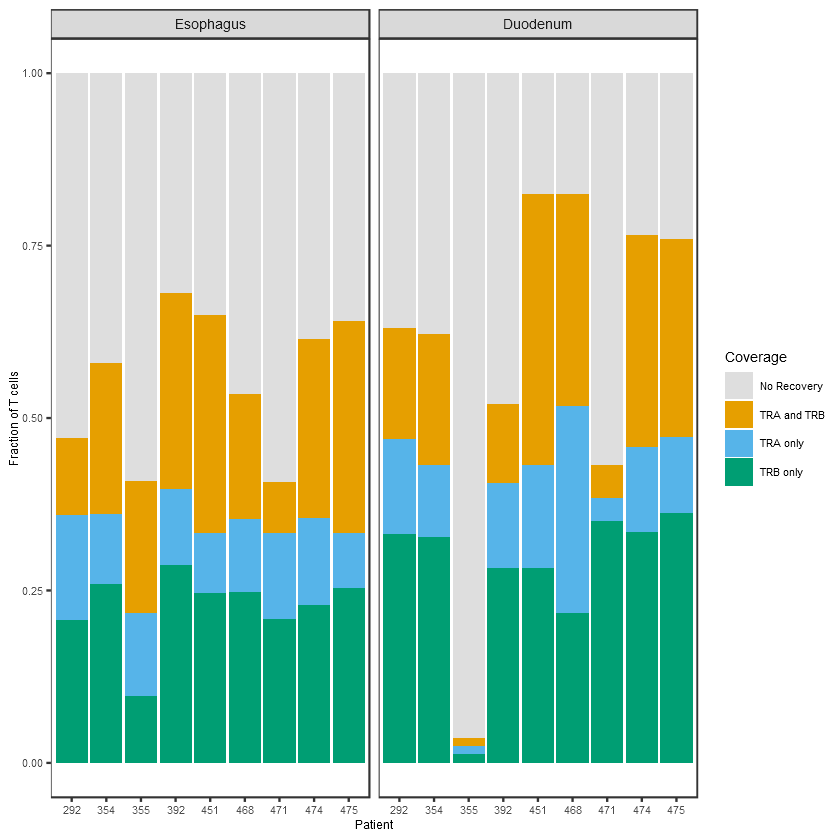

In [7]:
umi_seurat@meta.data$tissue = factor(as.character(umi_seurat@meta.data$tissue), levels = c("Esophagus", 'Duodenum'))
ggplot(umi_seurat@meta.data %>% filter(patient != 249, !pheno %in% c('NK', 'D_Ki-67+')), aes(x = factor(patient), fill = TCR_Recovery)) + geom_bar(position = 'fill') +
facet_wrap(~tissue)+scale_fill_manual("Coverage", values = c("TRA only" = cbPalette[3], "TRB only" = cbPalette[4], "TRA and TRB" = cbPalette[2], 'No Recovery' = cbPalette[1])) + remove_grid + Axis_themes +
labs(x = 'Patient', y = 'Fraction of T cells')
ggsave('TCRrecovery.pdf', height = 3, width = 5, useDingbats = FALSE)

In [8]:
# TCR profiling was not performed on patient 249
table(umi_seurat@meta.data$TCR_Recovery[umi_seurat@meta.data$patient != 249])
sum(umi_seurat@meta.data$patient != 249)


No Recovery TRA and TRB    TRA only    TRB only 
       2562        1426         842        1688 

[1] 6518

In [9]:
(1402)/6518
(1402+1878)/6518
(1402+722)/6518

[1] 0.2150967

[1] 0.5032218

[1] 0.3258668

In [10]:
saveRDS(umi_seurat, 'Data/tcrCDR3.RDS')